# Getting started with BigQuery ML

BigQuery ML enables users to create and execute machine learning models in BigQuery using SQL queries. The goal is to democratize machine learning by enabling SQL practitioners to build models using their existing tools and to increase development speed by eliminating the need for data movement.

In this tutorial, you use the sample [Google Analytics sample dataset for BigQuery](https://support.google.com/analytics/answer/7586738?hl=en&ref_topic=3416089) to create a model that predicts whether a website visitor will make a transaction. For information on the schema of the Analytics dataset, see [BigQuery export schema](https://support.google.com/analytics/answer/3437719) in the Google Analytics Help Center.


## Objectives
In this tutorial, you use:

+ BigQuery ML to create a binary logistic regression model using the `CREATE MODEL` statement
+ The `ML.EVALUATE` function to evaluate the ML model
+ The `ML.PREDICT` function to make predictions using the ML model

## Create your dataset

Enter the following code to import the BigQuery Python client library and initialize a client. The BigQuery client is used to send and receive messages from the BigQuery API.

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(location="US")

Next, you create a BigQuery dataset to store your ML model. Run the following to create your dataset:

In [ ]:
dataset = client.create_dataset("bqml_tutorial")

## Create your model

Next, you create a logistic regression model using the Google Analytics sample
dataset for BigQuery. The model is used to predict whether a
website visitor will make a transaction. The standard SQL query uses a
`CREATE MODEL` statement to create and train the model. Standard SQL is the
default query syntax for the BigQuery python client library.

The BigQuery python client library provides a cell magic,
`%%bigquery`, which runs a SQL query and returns the results as a Pandas
`DataFrame`.

To run the `CREATE MODEL` query to create and train your model:

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `bqml_tutorial.sample_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170630'

The query takes several minutes to complete. After the first iteration is
complete, your model (`sample_model`) appears in the navigation panel of the
BigQuery web UI. Because the query uses a `CREATE MODEL` statement to create a
table, you do not see query results. The output is an empty `DataFrame`.

## Get training statistics

To see the results of the model training, you can use the
[`ML.TRAINING_INFO`](/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train)
function, or you can view the statistics in the BigQuery web UI. This functionality
is not currently available in the BigQuery Classic web UI.
In this tutorial, you use the `ML.TRAINING_INFO` function.

A machine learning algorithm builds a model by examining many examples and
attempting to find a model that minimizes loss. This process is called empirical
risk minimization.

Loss is the penalty for a bad prediction &mdash; a number indicating
how bad the model's prediction was on a single example. If the model's
prediction is perfect, the loss is zero; otherwise, the loss is greater. The
goal of training a model is to find a set of weights that have low
loss, on average, across all examples.

To see the model training statistics that were generated when you ran the
`CREATE MODEL` query:

In [ ]:
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_tutorial.sample_model`)

Note: Typically, it is not a best practice to use a `SELECT *` query. Because the model output is a small table, this query does not process a large amount of data. As a result, the cost is minimal.

When the query is complete, the results appear below the query. The results should look like the following:
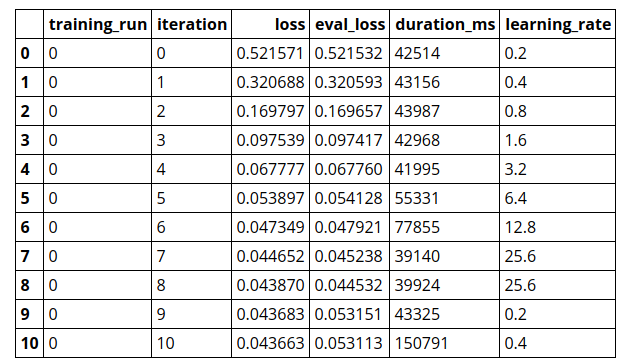

The `loss` column represents the loss metric calculated after the given iteration
on the training dataset. Since you performed a logistic regression, this column
is the [log loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression).
The `eval_loss` column is the same loss metric calculated on
the holdout dataset (data that is held back from training to validate the model).

For more details on the `ML.TRAINING_INFO` function, see the
[BigQuery ML syntax reference](/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train).

## Evaluate your model

After creating your model, you evaluate the performance of the classifier using
the [`ML.EVALUATE`](/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)
function. You can also use the [`ML.ROC_CURVE`](/bigquery/docs/reference/standard-sql/bigqueryml-syntax-roc)
function for logistic regression specific metrics.

A classifier is one of a set of enumerated target values for a label. For
example, in this tutorial you are using a binary classification model that
detects transactions. The two classes are the values in the `label` column:
`0` (no transactions) and not `1` (transaction made).

To run the `ML.EVALUATE` query that evaluates the model:

In [ ]:
%%bigquery
SELECT
  *
FROM ML.EVALUATE(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IF(totals.transactions IS NULL, 0, 1) AS label,
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(geoNetwork.country, "") AS country,
    IFNULL(totals.pageviews, 0) AS pageviews
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))

When the query is complete, the results appear below the query. The
results should look like the following:
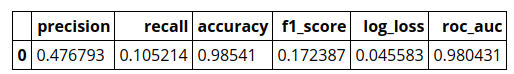

Because you performed a logistic regression, the results include the following
columns:

+ [`precision`](https://developers.google.com/machine-learning/glossary/#precision)
+ [`recall`](https://developers.google.com/machine-learning/glossary/#recall)
+ [`accuracy`](https://developers.google.com/machine-learning/glossary/#accuracy)
+ [`f1_score`](https://en.wikipedia.org/wiki/F1_score)
+ [`log_loss`](https://developers.google.com/machine-learning/glossary/#Log_Loss)
+ [`roc_auc`](https://developers.google.com/machine-learning/glossary/#AUC)


## Use your model to predict outcomes

Now that you have evaluated your model, the next step is to use it to predict
outcomes. You use your model to predict the number of transactions made by
website visitors from each country. And you use it to predict purchases per user.

To run the query that uses the model to predict the number of transactions:

In [ ]:
%%bigquery
SELECT
  country,
  SUM(predicted_label) as total_predicted_purchases
FROM ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  GROUP BY country
  ORDER BY total_predicted_purchases DESC
  LIMIT 10

When the query is complete, the results appear below the query. The
results should look like the following. Because model training is not
deterministic, your results may differ.

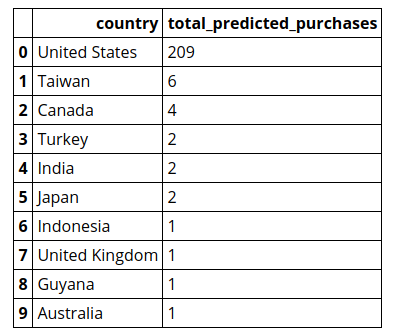

In the next example, you try to predict the number of transactions each website
visitor will make. This query is identical to the previous query except for the
`GROUP BY` clause. Here the `GROUP BY` clause &mdash; `GROUP BY fullVisitorId`
&mdash; is used to group the results by visitor ID.

To run the query that predicts purchases per user:

In [ ]:
%%bigquery
SELECT
  fullVisitorId,
  SUM(predicted_label) as total_predicted_purchases
FROM ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country,
    fullVisitorId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  GROUP BY fullVisitorId
  ORDER BY total_predicted_purchases DESC
  LIMIT 10

When the query is complete, the results appear below the query. The
results should look like the following:
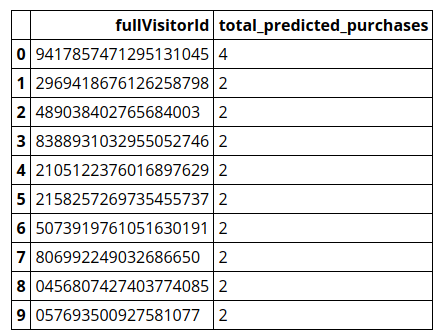

## Cleaning up

To delete the resources created by this tutorial, execute the following code to delete the dataset and its contents:

In [ ]:
client.delete_dataset(dataset, delete_contents=True)